In this notebook, we provide example code for computing gravitional waveforms from extreme-mass-ratio inspirals using the local kludge scheme (AKA the Chimera) introduced in [Sopuerta & Yunes, 2011](https://arxiv.org/abs/1109.0572) (hereafter Ref. [1]). In the introduction we provide a brief overview of our numerical implementation of the Chimera in order to explain the user-level options in the evolution master functions.

# Introduction

Schematically, our implementation of the Chimera is as follows:

1. Numerically evolve the geodesic equation with the initial constants of motion and initial conditions for a time $\Delta{T}$.

2. Compute the multipole moment derivatives required for waveform generation. These (up to 3rd order) time derivatives are computed using finite differences.

3. Compute the multipole moment derivatives required for the self-force computation. These (up to 6th order) time derivatives are computed using Julia's base backslash operator to solve a linear system for the coefficients of a truncated Fourier series expansion of the multipole moments. With these coefficients, the derivatives are computed via analytic differentiation of the Fourier series.

4. Compute the self-acceleration, use this to update the constants of motion, and evolve the next piecewise geodesic with the updated constants. Continue until the EMRI has been evolved for the specified amount of time.

The parameters of used in this notebook are set in the "params.jl" file.

# Preliminaries

To change the number of threads, run the cell below and then change the notebook's kernel to the newly created one. The kernel might need to be refreshed before the new kernel comes up as an option.

In [1]:
# using IJulia
# installkernel("Julia 4 threads", env=Dict("JULIA_NUM_THREADS"=>"4"));
Threads.nthreads()

4

Upon running this notebook for the first time, the following cell must be evaluated.

In [2]:
# include("../dependencies.jl");

The underlying parameters used in this notebook can be changed in the "params.jl" file.

In [3]:
using HDF5, LaTeXStrings, Plots.PlotMeasures, Plots
include("params.jl");

# Compute inspiral

Using four threads, it takes ~40 secs (after JIT compilation) to evolve this inspiral for a duration of 3 hours.

In [4]:
include("compute_inspiral.jl");

** JIT compilation run **
JIT compilation run complete.
 71.990145 seconds (31.11 M allocations: 1.986 GiB, 1.61% gc time, 105.07% compilation time: <1% of which was recompilation)
** Running with only mass quadrupole **
File created: ../Results/Data/EMRI_sol_a_0.98_p_7.0_e_0.6_θmin_0.569_q_1.0e-5_psi0_0.1_chi0_0.2_phi0_0.3_nHarm_2_fit_range_factor_0.5_Mino_fourier_Julia_fit_mass_quad_true.h5
 12.125761 seconds (12.99 M allocations: 2.369 GiB, 4.23% gc time, 5.42% compilation time)
** Running with all available modes **
File created: ../Results/Data/EMRI_sol_a_0.98_p_7.0_e_0.6_θmin_0.569_q_1.0e-5_psi0_0.1_chi0_0.2_phi0_0.3_nHarm_2_fit_range_factor_0.5_Mino_fourier_Julia_fit_mass_quad_false.h5
 32.576854 seconds (22.83 M allocations: 7.946 GiB, 4.93% gc time)


# Plot constants of motion

We first load the data from the inspiral.

In [5]:
# load trajectory
λ, t, r, θ, ϕ, dr_dt, dθ_dt, dϕ_dt, d2r_dt2, d2θ_dt2, d2ϕ_dt2, dt_dτ, dt_dλ = ChimeraInspiral.FourierFit.MinoTime.load_trajectory(a, p, e, θmin, q, psi0, chi0, phi0, nHarm, fit_time_range_factor, fit_type, data_path; mass_quad = mass_quad);
t = t * MtoSecs;

# load fluxes
t_Fluxes, EE, Edot, LL, Ldot, QQ, Qdot, CC, Cdot, pArray, ecc, θminArray = ChimeraInspiral.FourierFit.MinoTime.load_constants_of_motion(a, p, e, θmin, q, psi0, chi0, phi0, nHarm, fit_time_range_factor, fit_type, data_path; mass_quad = mass_quad);
t_Fluxes = t_Fluxes * MtoSecs;

# compute iota
ι = @. acos(LL / sqrt(LL^2 + CC));

In [6]:
col = :blue
ls = :solid
lw = 2.0

wave_im_ratio = 5   # width / height
wave_height = 300; wave_width = wave_height * wave_im_ratio
xtickfontsize=10; ytickfontsize=10; guidefontsize=15;
# margins
left_margin = 8mm; right_margin=8mm; top_margin=8mm; bottom_margin=8mm;

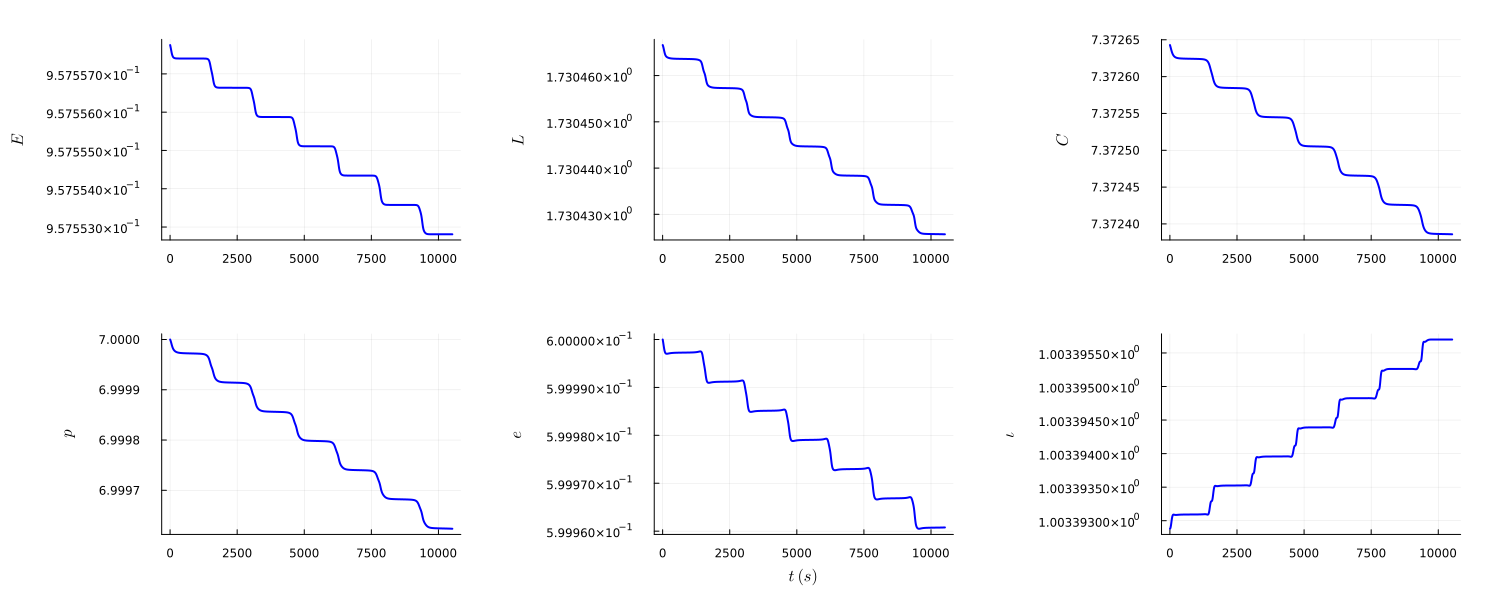

In [7]:
gr()
# plot BL results
plotE = Plots.plot(t_Fluxes, EE, ylabel=L"E", legend=:false,
    color=col, linestyle=ls, linewidth=lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotL = Plots.plot(t_Fluxes, LL, ylabel=L"L", legend=:false,
    color=col, linestyle=ls, linewidth=lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotC = Plots.plot(t_Fluxes, CC, ylabel=L"C", legend=:false,
    color=col, linestyle=ls, linewidth=lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotP = Plots.plot(t_Fluxes, pArray, ylabel=L"p", legend=:false, 
    color=col, linestyle=ls, linewidth=lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotEcc = Plots.plot(t_Fluxes, ecc, ylabel=L"e", xlabel=L"t\ (s)", legend=:false,
    color=col, linestyle=ls, linewidth=lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotι = Plots.plot(t_Fluxes, ι, ylabel=L"\iota", legend=:false,
    color=col, linestyle=ls, linewidth=lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)


orbitalParamsPlot=plot(plotE, plotL, plotC, plotP, plotEcc, plotι, layout = @layout([[A B C]; [D E F]]), 
size=(1500, 600), dpi=100)
display("image/png", orbitalParamsPlot)

# Waveform computation

We now compute and plot the waveforms. We include mass moments up to $l=4$ and current moments up to $l=3$. The plus/cross polarization vectors in the source frame are given by $\mathbf{x}_w$, $\mathbf{y}_w$ as defined in Eq. 6 in [2104.04582](https://arxiv.org/pdf/2104.04582).

Below we compare the waveforms containing only the mass quadrupole to waveforms including all available modes.

In [8]:
# include only mass quadrupole
@time ChimeraInspiral.FourierFit.MinoTime.compute_waveform(obs_distance, ThetaSource, PhiSource, ThetaKerr, PhiKerr, a, p, e, θmin, q, psi0, chi0, phi0, nHarm, fit_time_range_factor, fit_type, data_path; mass_quad=true);
t_wf_quad, h_plus_quad, h_cross_quad = ChimeraInspiral.FourierFit.MinoTime.load_waveform(obs_distance, ThetaSource, PhiSource, ThetaKerr, PhiKerr, a, p, e, θmin, q, psi0, chi0, phi0, nHarm, fit_time_range_factor, fit_type, data_path; mass_quad=true);
t_wf_quad *= MtoSecs;


# include all available modes
@time ChimeraInspiral.FourierFit.MinoTime.compute_waveform(obs_distance, ThetaSource, PhiSource, ThetaKerr, PhiKerr, a, p, e, θmin, q, psi0, chi0, phi0, nHarm, fit_time_range_factor, fit_type, data_path; mass_quad=false);
t_wf, h_plus, h_cross = ChimeraInspiral.FourierFit.MinoTime.load_waveform(obs_distance, ThetaSource, PhiSource, ThetaKerr, PhiKerr, a, p, e, θmin, q, psi0, chi0, phi0, nHarm, fit_time_range_factor, fit_type, data_path; mass_quad=false);
t_wf *= MtoSecs;

File created: ../Results/Data/Waveform_a_0.98_p_7.0_e_0.6_θmin_0.569_q_1.0e-5_psi0_0.1_chi0_0.2_phi0_0.3_obsDist_1.0_ThetaS_0.1_PhiS_0.2_ThetaK_0.3_PhiK_0.4_nHarm_2_fit_range_factor_0.5_Mino_fourier_Julia_fit_mass_quad_true.h5
  0.570049 seconds (46.80 k allocations: 38.311 MiB, 8.80% gc time, 94.62% compilation time)
File created: ../Results/Data/Waveform_a_0.98_p_7.0_e_0.6_θmin_0.569_q_1.0e-5_psi0_0.1_chi0_0.2_phi0_0.3_obsDist_1.0_ThetaS_0.1_PhiS_0.2_ThetaK_0.3_PhiK_0.4_nHarm_2_fit_range_factor_0.5_Mino_fourier_Julia_fit_mass_quad_false.h5
  1.116172 seconds (59.98 M allocations: 959.306 MiB, 21.67% gc time, 44.14% compilation time)


In [9]:
col_2 = :red
ls_2 = :dash
lw_2 = lw

2.0

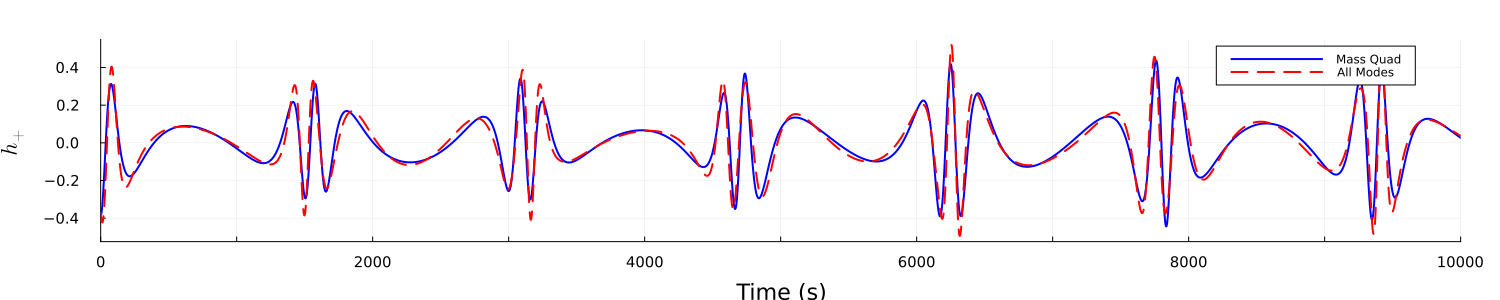

In [10]:
# NOTE: can multiply by "strain_to_SI" to convert waveform to SI units
gr()
p1 = plot(t_wf_quad, h_plus_quad, 
color=col,
linestyle=ls,
linewidth=lw,
xlims=(0, 10000),
legend =:topright,
xticks=(0:1000:10000, ["0", "", "2000", "", "4000", "", "6000", "", "8000", "", "10000"]),
xlabel = "Time (s)",
ylabel = L"h_{+}",
label = "Mass Quad",
size=(wave_width, wave_height),
left_margin		=  left_margin,
right_margin	=  right_margin,
top_margin		=  top_margin,
bottom_margin	=  bottom_margin,
xtickfontsize = xtickfontsize,
ytickfontsize = ytickfontsize,
guidefontsize = guidefontsize,
dpi=100)

plot!(p1, t_wf, h_plus, color=col_2, linestyle=ls_2, linewidth=lw_2, label="All Modes")

display("image/png", p1)

Waveforms can also be computed with respect to polarization vectors given by the orthonormal spherical basis vectors $\mathbf{e}_{\Theta}$ and $\mathbf{e}_{\Phi}$ as defined in Eq. 21 in [0607007](https://arxiv.org/pdf/gr-qc/0607007).

In [11]:
ThetaObs = 0.4;
PhiObs = 0.8;

In [12]:
@time ChimeraInspiral.FourierFit.MinoTime.compute_waveform(obs_distance, ThetaObs, PhiObs, a, p, e, θmin, q, psi0, chi0, phi0, nHarm, fit_time_range_factor, fit_type, data_path; mass_quad=false);
t_wf, h_plus, h_cross = ChimeraInspiral.FourierFit.MinoTime.load_waveform(obs_distance, ThetaObs, PhiObs, a, p, e, θmin, q, psi0, chi0, phi0, nHarm, fit_time_range_factor, fit_type, data_path; mass_quad=false);

File created: ../Results/Data/Waveform_a_0.98_p_7.0_e_0.6_θmin_0.569_q_1.0e-5_psi0_0.1_chi0_0.2_phi0_0.3_obsDist_1.0_ThetaObs_0.4_PhiObs_0.8_nHarm_2_fit_range_factor_0.5_Mino_fourier_Julia_fit_mass_quad_false.h5
  1.301645 seconds (89.92 M allocations: 1.381 GiB, 26.19% gc time, 36.61% compilation time)


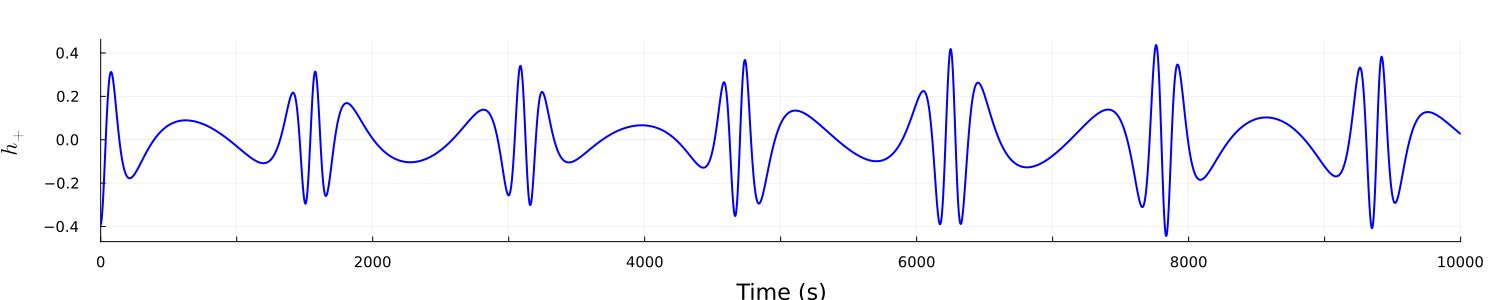

In [13]:
# NOTE: can multiply by "strain_to_SI" to convert waveform to SI units
gr()
p1 = plot(t_wf_quad, h_plus_quad, 
color=col,
linestyle=ls,
linewidth=lw,
xlims=(0, 10000),
legend =false,
xticks=(0:1000:10000, ["0", "", "2000", "", "4000", "", "6000", "", "8000", "", "10000"]),
xlabel = "Time (s)",
ylabel = L"h_{+}",
size=(wave_width, wave_height),
left_margin		=  left_margin,
right_margin	=  right_margin,
top_margin		=  top_margin,
bottom_margin	=  bottom_margin,
xtickfontsize = xtickfontsize,
ytickfontsize = ytickfontsize,
guidefontsize = guidefontsize,
dpi=100)

display("image/png", p1)